In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA, NMF
import piscola as pisco

# ntf
import tensorly as tl
from tensorly.decomposition import parafac, non_negative_parafac, non_negative_tucker

# for absolute magnitudes
from astropy.cosmology import FlatLambdaCDM  
import astropy.units as u
cosmo = FlatLambdaCDM(H0=72.0 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import pickle
with open('rcparams.pickle', 'rb') as file:
    rcparams = pickle.load(file)
    plt.rcParams.update(rcparams)

### Set data

In [2]:
sample_name = 'sifto'
sample_df = pd.read_csv(f'{sample_name}_sample.csv')

sn_names = sample_df.sn.values

bands = ['Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I']
features_dict = {band:{'flux':[], 'phase':[], 'sn':[], 'abs_mag':[]} for band in bands}
params_dict = {'sn':[], 'mb':[], 'dm15':[], 'color':[], 'MB':[]}

for name in sn_names:
    sn = pisco.load_sn(name, path='obj/')
    mu = cosmo.distmod(sn.z).value

    for band in bands:
        try:
            j = 100
            phase, flux = sn.lc_final_fits[band]['phase'][::j], sn.lc_final_fits[band]['flux'][::j]

            abs_flux = flux * 10**(0.4*mu)  # absolute flux
            features_dict[band]['flux'].append(abs_flux)  
            features_dict[band]['phase'].append(phase)
            features_dict[band]['sn'].append(name)

        except:
            pass

    sn_info = sample_df[sample_df.sn==name]
    mb = sn_info['mb'].values[0]
    dm15 = sn_info['dm15'].values[0]
    color = sn_info['color'].values[0]

    params_dict['sn'].append(name)
    params_dict['mb'].append(mb)
    params_dict['dm15'].append(dm15)
    params_dict['color'].append(color)
    params_dict['MB'].append(mb - mu)
    
features_df = {band:None for band in bands}
phases = np.round(np.arange(-10, 20.1, 0.1), 1)

for band in bands:
    fluxes = []
    for sn_phases, sn_fluxes in zip(features_dict[band]['phase'], features_dict[band]['flux']):
        phase_fluxes = np.empty(0)
        for phase in phases:
            if phase in np.round(sn_phases, 1):
                i = np.argmin(np.abs(phase-sn_phases))
                phase_fluxes = np.r_[phase_fluxes, sn_fluxes[i]]
            else:
                phase_fluxes = np.r_[phase_fluxes, np.nan]
        fluxes.append(phase_fluxes)

    fluxes = np.asarray(fluxes)
    print(band, fluxes.shape)
    
    new_col = {phase:col for phase, col in zip(phases, fluxes.T)}
    new_col['sn'] = features_dict[band]['sn']
    features_df[band] = pd.DataFrame(new_col)
    features_df[band] = features_df[band].set_index('sn')
    
init_params_df = pd.DataFrame(params_dict).set_index('sn')

Bessell_U (326, 301)
Bessell_B (326, 301)
Bessell_V (326, 301)
Bessell_R (326, 301)
Bessell_I (326, 301)


___
___
___
# Light Curve Components Analysis
___


## Non-negative Matrix Factorization


In [4]:
"""
for name in params_df.index:
    sn = pisco.load_sn(name, path='obj/')
    sn.display_results('Bessell_U')
    
"""

"\nfor name in params_df.index:\n    sn = pisco.load_sn(name, path='obj/')\n    sn.display_results('Bessell_U')\n    \n"

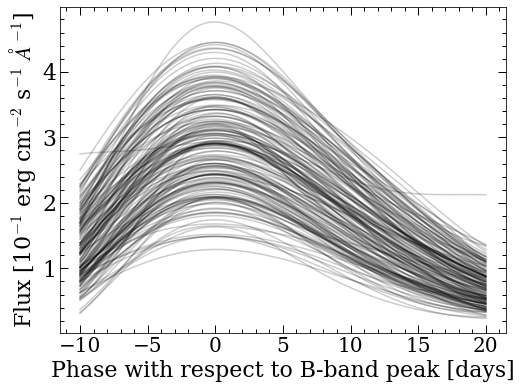

N = 176 SNe (Bessell_B)


In [5]:
band = 'Bessell_B'

feature_values = features_df[band].copy()
feature_values = feature_values.values
params_df = init_params_df[init_params_df.index.isin(features_df[band].index.values)]

# delete the SN with negative flux and
pos_idx = [i for i, sn_values in enumerate(feature_values) if all(sn_values>0.0)] 
feature_values = feature_values[pos_idx]
params_df = params_df.iloc[pos_idx]

exp = np.round(np.log10(feature_values[0].max()), 0)
y_norm = 10**exp    

# delete other SNe by eye
delete = True
if delete:
    delete_dict = {}   
    delete_dict['Bessell_U'] = ['SDSS6108', 'SDSS6699', 'SDSS6780', '05D2bv', '05D2ci']    
    delete_dict['Bessell_B'] = ['SDSS6773']
    delete_dict['Bessell_V'] = ['SDSS6773', 'SDSS3901']

    sn2detele = delete_dict[band]
    mask = params_df.index.isin(sn2detele)
    params_df = params_df[~mask]
    feature_values = feature_values[~mask]

fig, ax = plt.subplots(figsize=(8, 6))
for i, sn_flux in enumerate(feature_values):
    ax.plot(phases, sn_flux/y_norm, 'k', alpha=0.2)
    
ax.set_xlabel(f'Phase with respect to B-band peak [days]')
ax.set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp)

#plt.savefig(f'plots/{band}-band_lcs.pdf')
plt.show()

print(f'N = {len(params_df)} SNe ({band})')

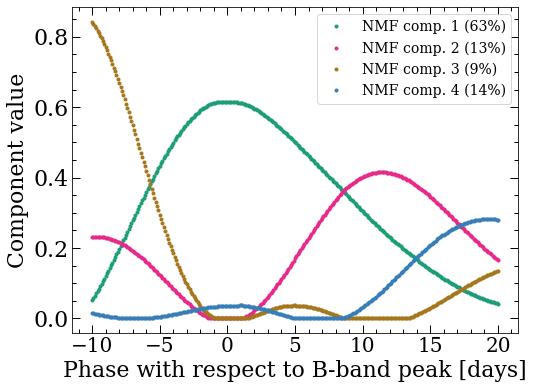

In [7]:
n_components = 4
reducer = NMF(n_components=n_components)
transformed_features = reducer.fit_transform(feature_values) # fits AND transforms at the same time

color_palette = [plt.get_cmap('Dark2')(i) for i in np.arange(8)] + [plt.get_cmap('Set1')(i) for i in np.arange(8)]
color_palette = color_palette[::3]

fig, ax = plt.subplots(figsize=(8, 6))
for i in np.arange(n_components):
    variance = transformed_features[:,i].var()/np.sum(transformed_features.var(axis=0))
    component_array = reducer.components_[i,:]
    ax.plot(phases, component_array, '.', 
            label = f'NMF comp. {i+1} ({int(np.round(100*variance, 0))}%)', color=color_palette[i])

ax.set_ylabel('Component value')
ax.set_xlabel('Phase with respect to B-band peak [days]')
ax.legend(fontsize=14)

#plt.savefig(f'plots/{band}-band_components.pdf')
plt.show()

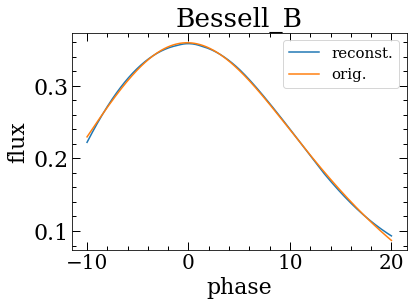

In [8]:
sn_id = 5

plt.plot(phases,  reducer.inverse_transform(transformed_features)[sn_id], label='reconst.')
plt.plot(phases, feature_values[sn_id], label='orig.')

plt.title(f'{band}')
plt.ylabel('flux')
plt.xlabel('phase')
plt.legend(fontsize=15);
#plt.savefig('plots/nmf_lc_reconstruction')

/home/tem1u17/anaconda3/envs/pysco/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


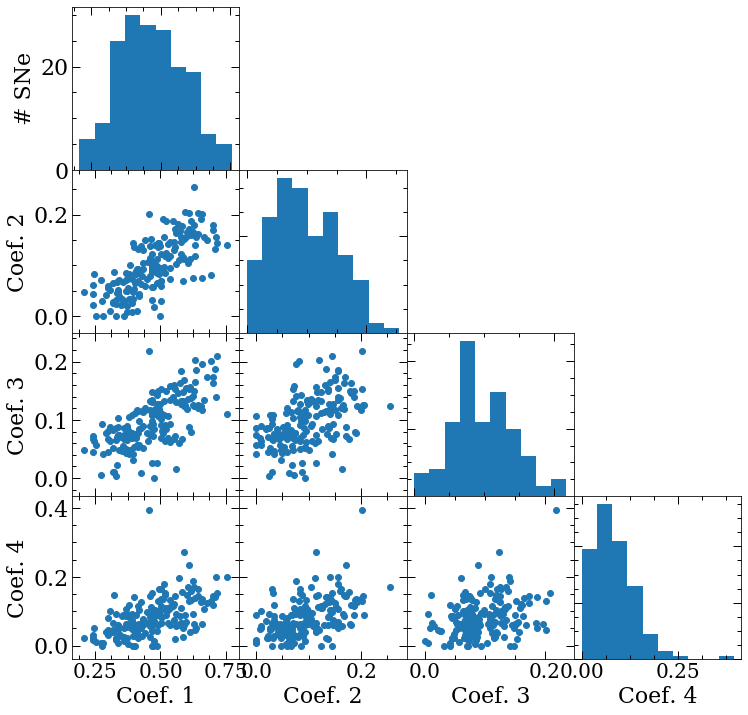

In [9]:
components_df = pd.DataFrame(data=transformed_features, columns=[f'CP{int(i+1)}' for i in np.arange(n_components)])
components_df['sn'] = params_df.index.values
sn_names = params_df.index.values
components_df = components_df.set_index('sn')

# constrains
#components_df = components_df[components_df.CP4<0.6]
#colour_values = params_df[params_df.index.isin(components_df.index.values)][param].values

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(n_components , n_components, wspace=0, hspace=0)
axs = []
for i in np.arange(n_components):
    
    ax = plt.subplot(gs[i, 0])
    if i==0:
        ax.set_ylabel(f'# SNe')
    else:
        ax.set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(i+1):
        
        ax = plt.subplot(gs[i, j])
        if i==j:
            ax.hist(components_df.values[:,i])
            if i!=n_components-1:
                ax.set_xticklabels([' ']*len(components_df.values[:,i]))
        else:    
            s = ax.scatter(components_df.values[:,j], components_df.values[:,i])
            
        if (i+1)==n_components:
            ax = plt.subplot(gs[i, j])
            ax.set_xlabel(f'Coef. {int(j+1)}')
        if j != 0:
            ax.set_yticklabels([' ']*len(components_df.values[:,i]))
            
    axs+=[ax]

#plt.savefig(f'plots/{band}-band_coefficients.pdf')
plt.show()

## Coefficients vs light-curve parameters

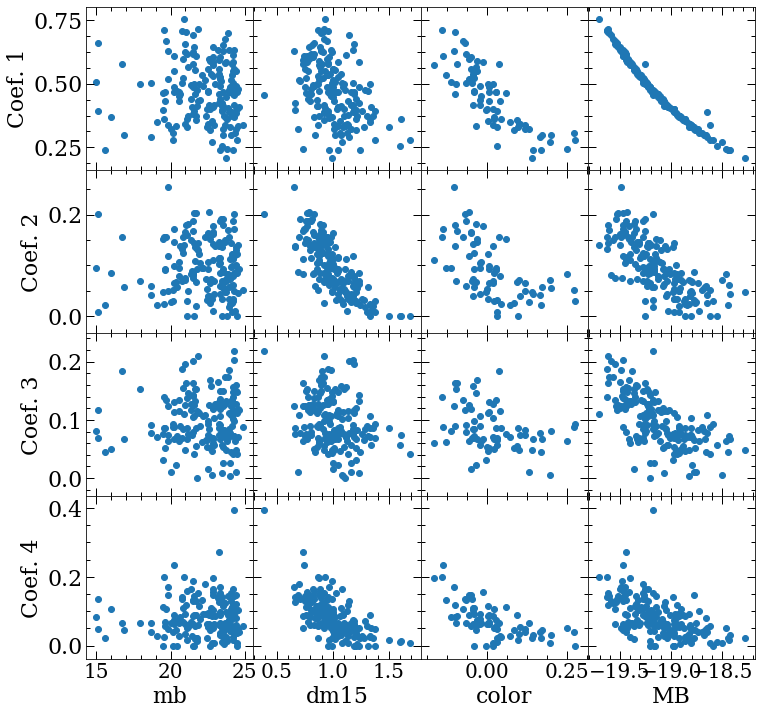

In [10]:
fig, ax = plt.subplots(n_components, n_components, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(n_components):
    
    ax[i, 0].set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(n_components):
        
        ax[i, j].scatter(params_df.values[:,j], components_df.values[:,i])
            
        if (i+1)==n_components:
            ax[i, j].set_xlabel(f'{params_df.columns[j]}')  

#plt.savefig(f'plots/{band}-band_coefficients_lcparams.pdf')
plt.show()

## Coefficients vs SALT2 parameters

In [11]:
jla_params = pd.read_csv('test_files/JLA/jla_lcparams.txt', delim_whitespace=True)
jla_params = jla_params[jla_params['#name'].isin(sn_names)]
mask = components_df.index.isin(jla_params['#name'])
components_df2 = components_df[mask].sort_index()

jla_df = jla_params[['mb', 'x1', 'color', 'zhel', '#name']]
jla_df = jla_df.set_index('#name')
jla_df = jla_df.sort_index()

# absolute magnitude
mu = cosmo.distmod(jla_df.zhel.values).value
MB = jla_df.mb.values - mu
jla_df['mb'] = MB
jla_df = jla_df.rename(columns={'mb':'MB'})

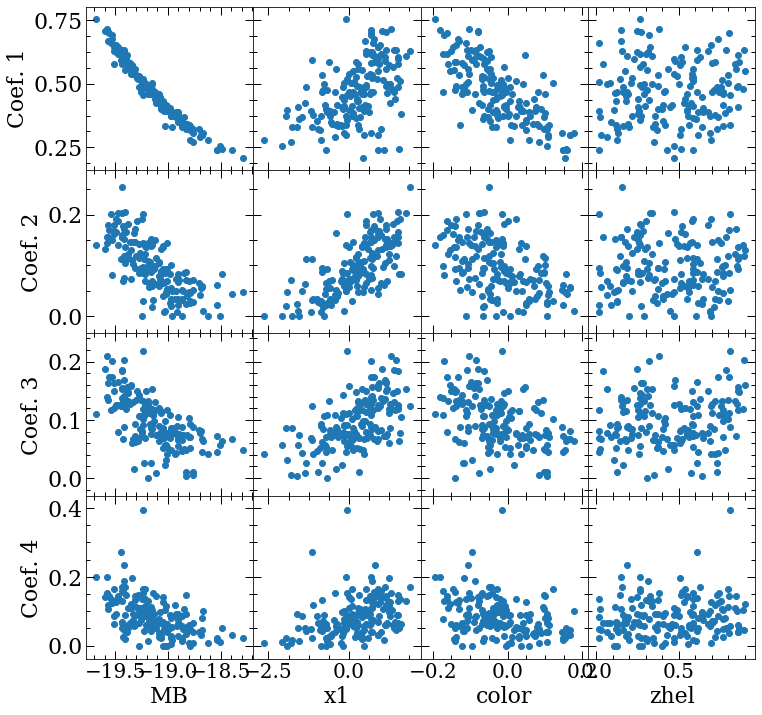

In [12]:
fig, ax = plt.subplots(n_components, n_components, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(n_components):
    
    ax[i, 0].set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(n_components):
        
        ax[i, j].scatter(jla_df.values[:,j], components_df2.values[:,i])
            
        if (i+1)==n_components:
            ax[i, j].set_xlabel(f'{jla_df.columns[j]}')  

#plt.savefig(f'plots/{band}-band_coefficients_lcparamsSALT.pdf')
plt.show()

## Coefficients vs SiFTO parameters

In [13]:
sifto_params = pd.read_csv('test_files/Sifto/sifto.dat', delim_whitespace=True)
sifto_params = sifto_params[sifto_params['#name'].isin(sn_names)]
mask = components_df.index.isin(sifto_params['#name'])
components_df2 = components_df[mask].sort_index()

sifto_df = sifto_params[['mb', 's', 'color', 'zhel', '#name']]
sifto_df = sifto_df.set_index('#name')
sifto_df = sifto_df.sort_index()

# absolute magnitude
mu = cosmo.distmod(sifto_df.zhel.values).value
MB = sifto_df.mb.values - mu
sifto_df['mb'] = MB
sifto_df = sifto_df.rename(columns={'mb':'MB'})

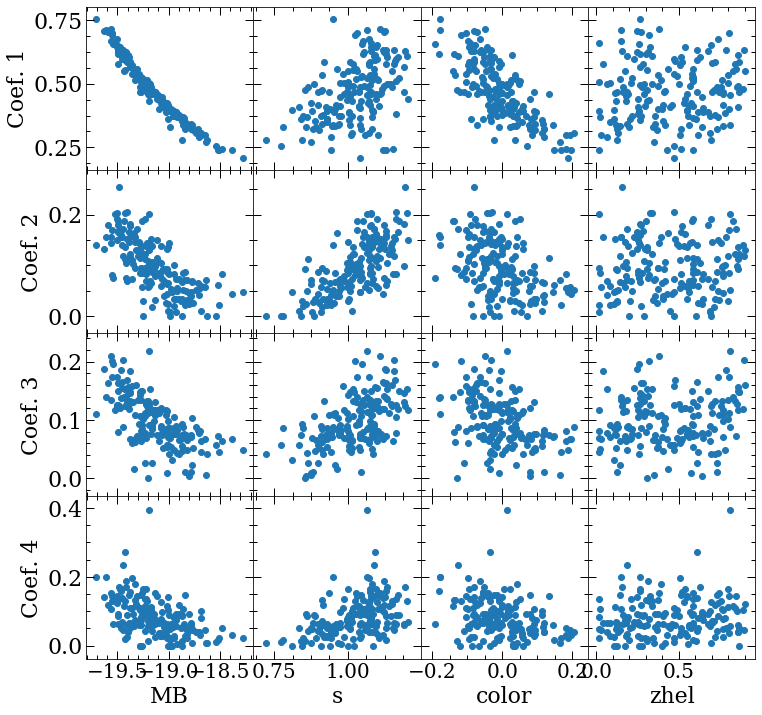

In [14]:
fig, ax = plt.subplots(n_components, n_components, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(n_components):
    
    ax[i, 0].set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(n_components):
        
        ax[i, j].scatter(sifto_df.values[:,j], components_df2.values[:,i])
            
        if (i+1)==n_components:
            ax[i, j].set_xlabel(f'{sifto_df.columns[j]}')  

#plt.savefig(f'plots/{band}-band_coefficients_lcparamsSiFTO.pdf')
plt.show()

___
## Independent Multi-bands

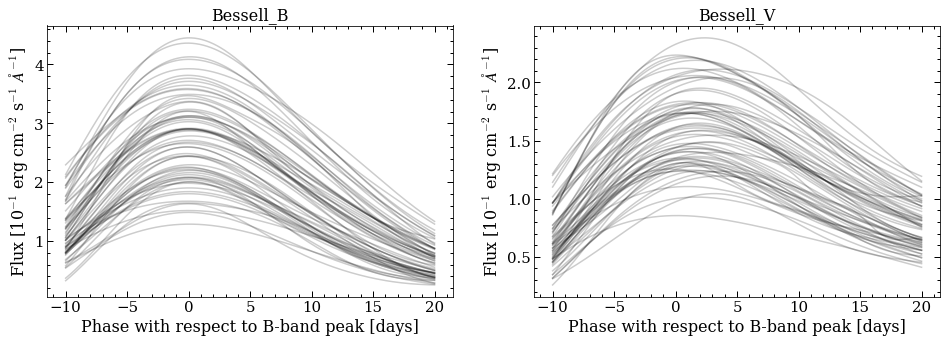

N = 65 SNe (Bessell_B+Bessell_V)


In [15]:
band1 = 'Bessell_B'
band2 = 'Bessell_V'

feature_values1 = features_df[band1].copy()
feature_values1 = feature_values1.values
params_df1 = init_params_df[init_params_df.index.isin(features_df[band1].index.values)]

feature_values2 = features_df[band2].copy()
feature_values2 = feature_values2.values
params_df2 = init_params_df[init_params_df.index.isin(features_df[band2].index.values)]

# delete the SN with negative flux
pos_idx1 = [i for i, sn_values in enumerate(feature_values1) if all(sn_values>0.0)] # delete the SN with negative flux
feature_values1 = feature_values1[pos_idx1]
params_df1 = params_df1.iloc[pos_idx1]

pos_idx2 = [i for i, sn_values in enumerate(feature_values2) if all(sn_values>0.0)] # delete the SN with negative flux
feature_values2 = feature_values2[pos_idx2]
params_df2 = params_df2.iloc[pos_idx2]

# delete other SNe by eye
delete = True
if delete:
    # band1
    sn2detele = delete_dict[band1]
    mask1 = params_df1.index.isin(sn2detele)
    params_df1 = params_df1[~mask1]
    feature_values1 = feature_values1[~mask1]
    
    # band2
    sn2detele = delete_dict[band2]
    mask2 = params_df2.index.isin(sn2detele)
    params_df2 = params_df2[~mask2]
    feature_values2 = feature_values2[~mask2]

# pick SNe in common
idx1 = [i for i, val in enumerate(params_df1.index.values) if val in params_df2.index.values]  
feature_values1 = feature_values1[idx1]
params_df1 = params_df1.iloc[idx1]


idx2 = [i for i, val in enumerate(params_df2.index.values) if val in params_df1.index.values]  # pick SNe in common
feature_values2 = feature_values2[idx2]
params_df2 = params_df2.iloc[idx2]

exp1 = np.round(np.log10(feature_values1[0].max()), 0)
y_norm1 = 10**exp1 

exp2 = np.round(np.log10(feature_values2[0].max()), 0)
y_norm2 = 10**exp2

f, ax = plt.subplots(1, 2, figsize=(16,5))
for val in feature_values1:
    ax[0].plot(phases, val/y_norm1, 'k', alpha=0.2)
    
ax[0].set_xlabel(f'Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax[0].set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp, fontsize = 16, family='serif')
ax[0].set_title(f'{band1}', fontsize = 16, family='serif')
ax[0].minorticks_on()
ax[0].tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax[0].tick_params(which='minor', length=3, width=1, direction='in', top=True, right=True, labelsize=15)

for val in feature_values2:
    ax[1].plot(phases, val/y_norm2, 'k', alpha=0.2)
    
ax[1].set_xlabel(f'Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax[1].set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp, fontsize = 16, family='serif')
ax[1].set_title(f'{band2}', fontsize = 16, family='serif')
ax[1].minorticks_on()
ax[1].tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax[1].tick_params(which='minor', length=3, width=1, direction='in', top=True, right=True, labelsize=15)

#plt.savefig(f'plots/lcs_{band}{y_label}.png')
plt.show()

print(f'N = {len(params_df1)} SNe ({band1}+{band2})')

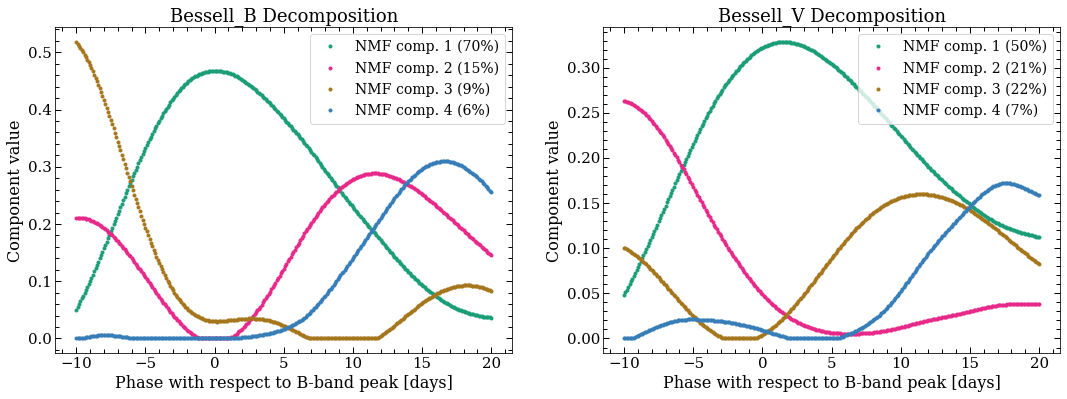

In [16]:
n_components = 4
reducer1 = NMF(n_components = n_components)
reducer2 = NMF(n_components = n_components)

# fits AND transforms at the same time
transformed_features1 = reducer1.fit_transform(feature_values1) 
transformed_features2 = reducer2.fit_transform(feature_values2)

color_palette = [plt.get_cmap('Dark2')(i) for i in np.arange(8)] + [plt.get_cmap('Set1')(i) for i in np.arange(8)]
color_palette = color_palette[::3]

f, ax = plt.subplots(1, 2, figsize=(18,6))
for i in np.arange(n_components):
    variance = transformed_features1[:,i].var()/np.sum(transformed_features1.var(axis=0))
    ax[0].plot(phases, reducer1.components_[i,:], '.', 
             label = f'NMF comp. {i+1} ({int(np.round(100*variance, 0))}%)', color=color_palette[i])

ax[0].set_title(f'{band1} Decomposition', fontsize = 18, family='serif')
ax[0].set_ylabel('Component value', fontsize = 16, family='serif')
ax[0].set_xlabel('Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax[0].tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax[0].legend(fontsize=14, loc='upper right')


for i in np.arange(n_components):
    variance = transformed_features2[:,i].var()/np.sum(transformed_features2.var(axis=0))
    ax[1].plot(features_df[band2].columns.values, reducer2.components_[i,:], '.', 
             label = f'NMF comp. {i+1} ({int(np.round(100*variance, 0))}%)', color=color_palette[i])

ax[1].set_title(f'{band2} Decomposition', fontsize = 18, family='serif')
ax[1].set_ylabel('Component value', fontsize = 16, family='serif')
ax[1].set_xlabel('Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax[1].tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax[1].legend(fontsize=14, loc='upper right')

#plt.savefig(f'plots/BV_components.pdf')
plt.show()

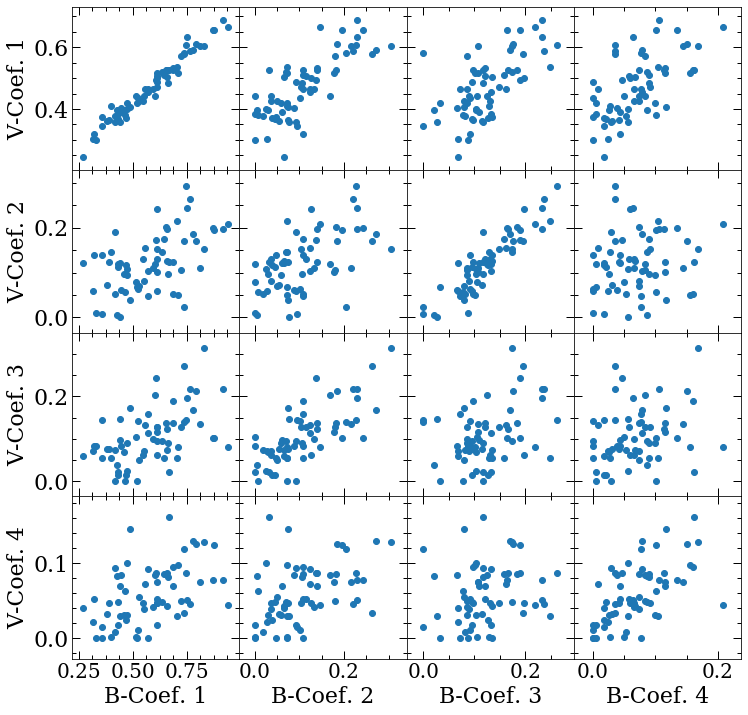

In [17]:
components_df1 = pd.DataFrame(data=transformed_features1, columns=[f'CP{int(i+1)}' for i in np.arange(n_components)])
components_df1['sn'] = params_df1.index.values
components_df1 = components_df1.set_index('sn')

components_df2 = pd.DataFrame(data=transformed_features2, columns=[f'CP{int(i+1)}' for i in np.arange(n_components)])
components_df2['sn'] = params_df2.index.values
components_df2 = components_df2.set_index('sn')

fig, ax = plt.subplots(n_components, n_components, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(n_components):
    
    ax[i, 0].set_ylabel(f'{band2[-1]}-Coef. {int(i+1)}')
    for j in np.arange(n_components):
        
        ax[i, j].scatter(components_df1.values[:,j], components_df2.values[:,i])
            
        if (i+1)==n_components:
            ax[i, j].set_xlabel(f'{band1[-1]}-Coef. {int(j+1)}')  

#plt.savefig(f'plots/BV_coefficients.pdf')
plt.show()

___
### Colour Curve

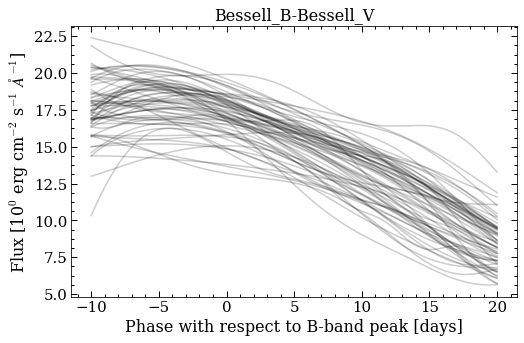

N = 65 SNe (Bessell_B+Bessell_V)


In [18]:
band1 = 'Bessell_B'
band2 = 'Bessell_V'

feature_values1 = features_df[band1].copy()
feature_values1 = feature_values1.values
params_df1 = init_params_df[init_params_df.index.isin(features_df[band1].index.values)]

feature_values2 = features_df[band2].copy()
feature_values2 = feature_values2.values
params_df2 = init_params_df[init_params_df.index.isin(features_df[band2].index.values)]

# delete the SN with negative flux
pos_idx1 = [i for i, sn_values in enumerate(feature_values1) if all(sn_values>0.0)] # delete the SN with negative flux
feature_values1 = feature_values1[pos_idx1]
params_df1 = params_df1.iloc[pos_idx1]

pos_idx2 = [i for i, sn_values in enumerate(feature_values2) if all(sn_values>0.0)] # delete the SN with negative flux
feature_values2 = feature_values2[pos_idx2]
params_df2 = params_df2.iloc[pos_idx2]

# delete other SNe by eye
delete = True
if delete:
    # band1
    sn2detele = delete_dict[band1]
    mask1 = params_df1.index.isin(sn2detele)
    params_df1 = params_df1[~mask1]
    feature_values1 = feature_values1[~mask1]
    
    # band2
    sn2detele = delete_dict[band2]
    mask2 = params_df2.index.isin(sn2detele)
    params_df2 = params_df2[~mask2]
    feature_values2 = feature_values2[~mask2]

# pick SNe in common
idx1 = [i for i, val in enumerate(params_df1.index.values) if val in params_df2.index.values]  
feature_values1 = feature_values1[idx1]
params_df1 = params_df1.iloc[idx1]


idx2 = [i for i, val in enumerate(params_df2.index.values) if val in params_df1.index.values]  # pick SNe in common
feature_values2 = feature_values2[idx2]
params_df2 = params_df2.iloc[idx2]

# colour curves
feature_values = feature_values1/feature_values2

exp = np.round(np.log10(feature_values[0].max()), 0)
y_norm = 10**exp


f, ax = plt.subplots(figsize=(8,5))
#i = 0
for val in feature_values:
    #print(params_df2.index.values[i])
    #i+=1
    ax.plot(phases, val/y_norm1, 'k', alpha=0.2)
    #plt.show()
    
ax.set_xlabel(f'Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax.set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp, fontsize = 16, family='serif')
ax.set_title(f'{band1}-{band2}', fontsize = 16, family='serif')
ax.minorticks_on()
ax.tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax.tick_params(which='minor', length=3, width=1, direction='in', top=True, right=True, labelsize=15)


#plt.savefig(f'plots/lcs_{band}{y_label}.png')
plt.show()

print(f'N = {len(params_df1)} SNe ({band1}+{band2})')

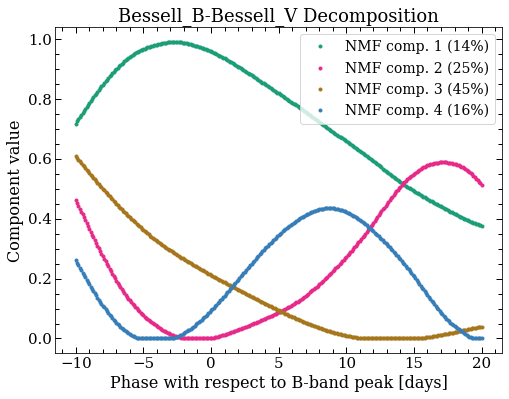

In [19]:
n_components = 4
reducer = NMF(n_components = n_components)

# fits AND transforms at the same time
transformed_features = reducer.fit_transform(feature_values) 

color_palette = [plt.get_cmap('Dark2')(i) for i in np.arange(8)] + [plt.get_cmap('Set1')(i) for i in np.arange(8)]
color_palette = color_palette[::3]

f, ax = plt.subplots(figsize=(8,6))
for i in np.arange(n_components):
    variance = transformed_features[:,i].var()/np.sum(transformed_features.var(axis=0))
    ax.plot(phases, reducer.components_[i,:], '.', 
             label = f'NMF comp. {i+1} ({int(np.round(100*variance, 0))}%)', color=color_palette[i])

ax.set_title(f'{band1}-{band2} Decomposition', fontsize = 18, family='serif')
ax.set_ylabel('Component value', fontsize = 16, family='serif')
ax.set_xlabel('Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax.tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax.legend(fontsize=14, loc='upper right')

#plt.savefig(f'plots/BV_components.pdf')
plt.show()

/home/tem1u17/anaconda3/envs/pysco/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


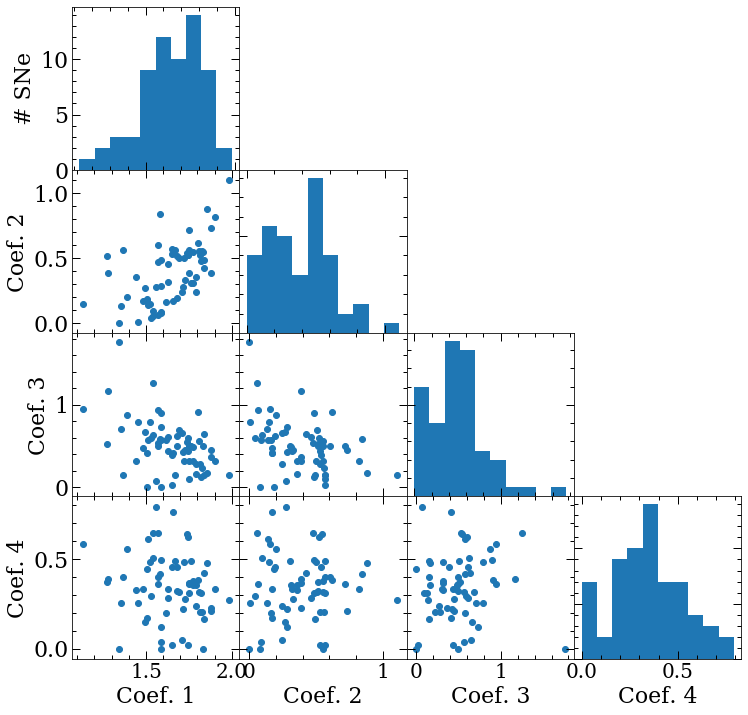

In [20]:
components_df = pd.DataFrame(data=transformed_features, columns=[f'CP{int(i+1)}' for i in np.arange(n_components)])
components_df['sn'] = params_df1.index.values
sn_names = params_df.index.values
components_df = components_df.set_index('sn')

# constrains
#components_df = components_df[components_df.CP4<0.6]
#colour_values = params_df[params_df.index.isin(components_df.index.values)][param].values

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(n_components , n_components, wspace=0, hspace=0)
axs = []
for i in np.arange(n_components):
    
    ax = plt.subplot(gs[i, 0])
    if i==0:
        ax.set_ylabel(f'# SNe')
    else:
        ax.set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(i+1):
        
        ax = plt.subplot(gs[i, j])
        if i==j:
            ax.hist(components_df.values[:,i])
            if i!=n_components-1:
                ax.set_xticklabels([' ']*len(components_df.values[:,i]))
        else:    
            s = ax.scatter(components_df.values[:,j], components_df.values[:,i])
            
        if (i+1)==n_components:
            ax = plt.subplot(gs[i, j])
            ax.set_xlabel(f'Coef. {int(j+1)}')
        if j != 0:
            ax.set_yticklabels([' ']*len(components_df.values[:,i]))
            
    axs+=[ax]

#plt.savefig(f'plots/{band}-band_coefficients.pdf')
plt.show()

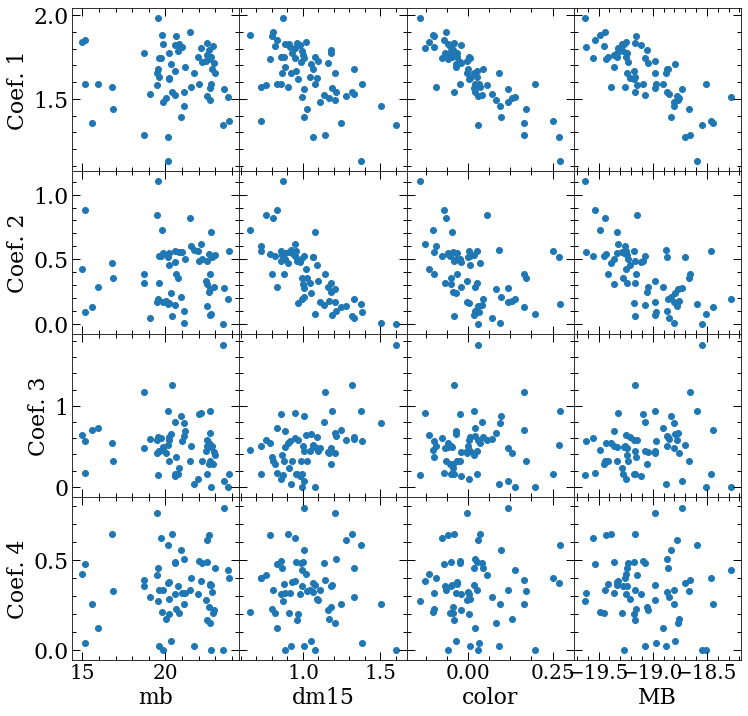

In [21]:
fig, ax = plt.subplots(n_components, n_components, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(n_components):
    
    ax[i, 0].set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(n_components):
        
        ax[i, j].scatter(params_df1.values[:,j], components_df.values[:,i])
            
        if (i+1)==n_components:
            ax[i, j].set_xlabel(f'{params_df.columns[j]}')  

#plt.savefig(f'plots/{band}-band_coefficients_lcparams.pdf')
plt.show()

___
### Parallel Multi-bands

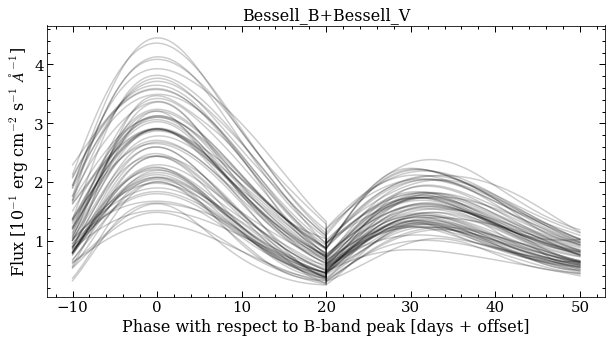

N = 65 SNe (Bessell_B+Bessell_V)


In [22]:
band1 = 'Bessell_B'
band2 = 'Bessell_V'

feature_values1 = features_df[band1].copy()
feature_values1 = feature_values1.values
params_df1 = init_params_df[init_params_df.index.isin(features_df[band1].index.values)]

feature_values2 = features_df[band2].copy()
feature_values2 = feature_values2.values
params_df2 = init_params_df[init_params_df.index.isin(features_df[band2].index.values)]

# delete the SN with negative flux
pos_idx1 = [i for i, sn_values in enumerate(feature_values1) if all(sn_values>0.0)] # delete the SN with negative flux
feature_values1 = feature_values1[pos_idx1]
params_df1 = params_df1.iloc[pos_idx1]

pos_idx2 = [i for i, sn_values in enumerate(feature_values2) if all(sn_values>0.0)] # delete the SN with negative flux
feature_values2 = feature_values2[pos_idx2]
params_df2 = params_df2.iloc[pos_idx2]

# delete other SNe by eye
delete = True
if delete:
    # band1
    sn2detele = delete_dict[band1]
    mask1 = params_df1.index.isin(sn2detele)
    params_df1 = params_df1[~mask1]
    feature_values1 = feature_values1[~mask1]
    
    # band2
    sn2detele = delete_dict[band2]
    mask2 = params_df2.index.isin(sn2detele)
    params_df2 = params_df2[~mask2]
    feature_values2 = feature_values2[~mask2]

# pick SNe in common
idx1 = [i for i, val in enumerate(params_df1.index.values) if val in params_df2.index.values]  
feature_values1 = feature_values1[idx1]
params_df1 = params_df1.iloc[idx1]

idx2 = [i for i, val in enumerate(params_df2.index.values) if val in params_df1.index.values]  # pick SNe in common
feature_values2 = feature_values2[idx2]
params_df2 = params_df2.iloc[idx2]
 

feature_values = np.asarray([np.r_[val1, val2] for val1, val2 in zip(feature_values1, feature_values2)])

exp = np.round(np.log10(feature_values[0].max()), 0)
y_norm = 10**exp

f, ax = plt.subplots(figsize=(10,5))
for val in feature_values:
    ax.plot(np.r_[phases, phases+(phases.max()-phases.min())], val/y_norm, 'k', alpha=0.2)
    
ax.set_xlabel(f'Phase with respect to B-band peak [days + offset]', fontsize = 16, family='serif')
ax.set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp, fontsize = 16, family='serif')
ax.set_title(f'{band1}+{band2}', fontsize = 16, family='serif')
ax.minorticks_on()
ax.tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax.tick_params(which='minor', length=3, width=1, direction='in', top=True, right=True, labelsize=15)

#plt.savefig(f'plots/lcs_{band}{y_label}.png')
plt.show()

print(f'N = {len(params_df1)} SNe ({band1}+{band2})')

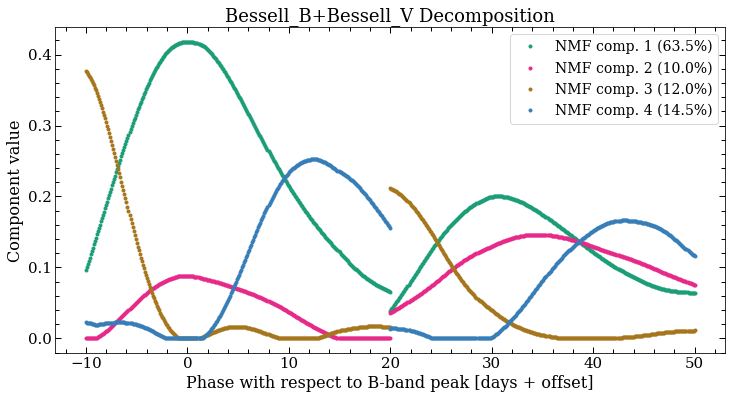

In [23]:
n_components = 4
reducer = NMF(n_components = n_components)
transformed_features = reducer.fit_transform(feature_values) 

color_palette = [plt.get_cmap('Dark2')(i) for i in np.arange(8)] + [plt.get_cmap('Set1')(i) for i in np.arange(8)]
color_palette = color_palette[::3]

f, ax = plt.subplots(figsize=(12,6))
for i in np.arange(n_components):
    variance = transformed_features[:,i].var()/np.sum(transformed_features.var(axis=0))
    ax.plot(np.r_[phases, phases+(phases.max()-phases.min())], reducer.components_[i,:], '.', 
             label = f'NMF comp. {i+1} ({np.round(100*variance, 1)}%)', color=color_palette[i])

ax.set_title(f'{band1}+{band2} Decomposition', fontsize = 18, family='serif')
ax.set_ylabel('Component value', fontsize = 16, family='serif')
ax.set_xlabel('Phase with respect to B-band peak [days + offset]', fontsize = 16, family='serif')
ax.tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax.legend(fontsize=14, loc='upper right')

#plt.savefig(f'plots/{decomposition}_{band}{y_label}_components.png')
plt.show()

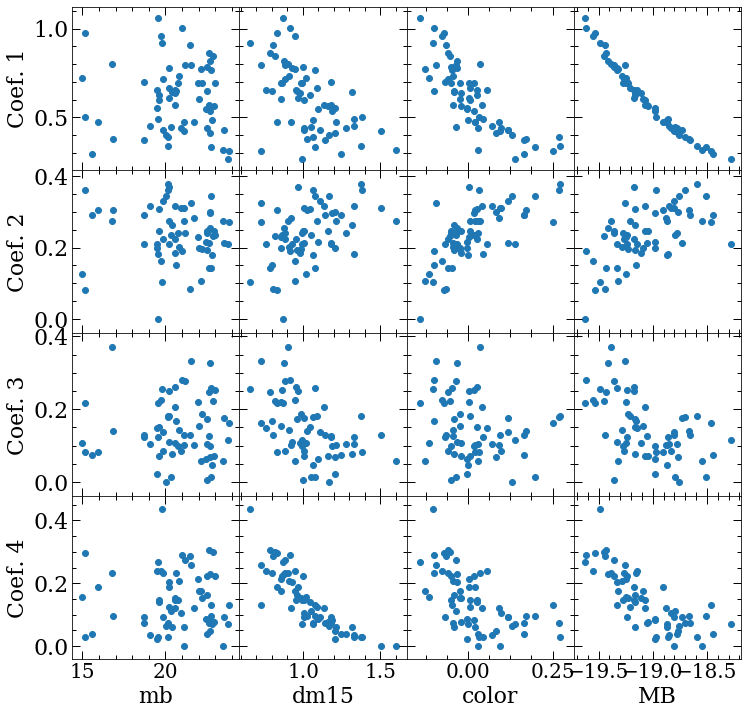

In [24]:
components_df = pd.DataFrame(data=transformed_features, columns=[f'CP{int(i+1)}' for i in np.arange(n_components)])
components_df['sn'] = params_df1.index.values
components_df = components_df.set_index('sn')

fig, ax = plt.subplots(n_components, n_components, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(n_components):
    
    ax[i, 0].set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(n_components):
        
        ax[i, j].scatter(params_df1.values[:,j], components_df.values[:,i])
            
        if (i+1)==n_components:
            ax[i, j].set_xlabel(f'{params_df1.columns[j]}')  

plt.show()

/home/tem1u17/anaconda3/envs/pysco/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


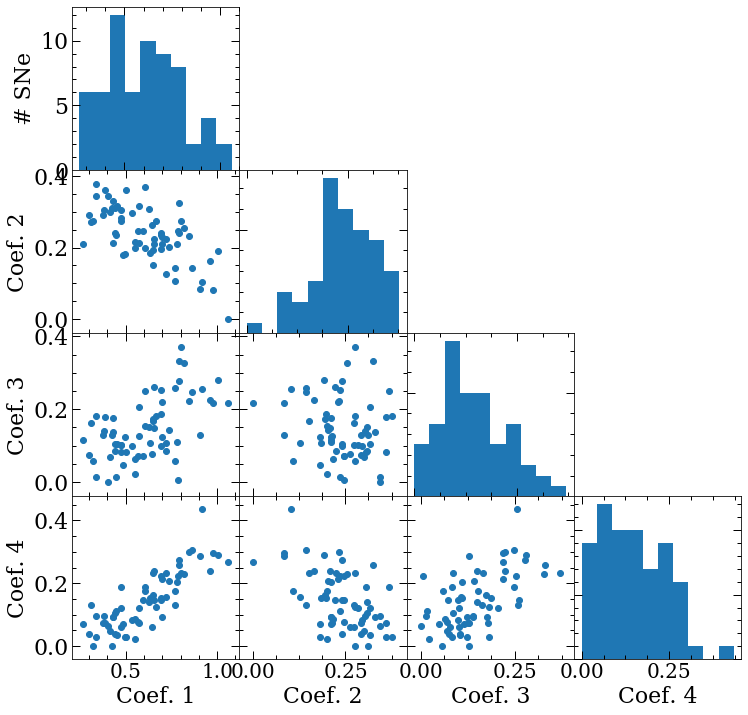

In [25]:
components_df = pd.DataFrame(data=transformed_features, columns=[f'CP{int(i+1)}' for i in np.arange(n_components)])
components_df['sn'] = params_df1.index.values
components_df = components_df.set_index('sn')

# constrains
#components_df = components_df[components_df.CP4<0.6]
#colour_values = params_df[params_df.index.isin(components_df.index.values)][param].values

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(n_components , n_components, wspace=0, hspace=0)
axs = []
for i in np.arange(n_components):
    
    ax = plt.subplot(gs[i, 0])
    if i==0:
        ax.set_ylabel(f'# SNe')
    else:
        ax.set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(i+1):
        
        ax = plt.subplot(gs[i, j])
        if i==j:
            ax.hist(components_df.values[:,i])
            if i!=n_components-1:
                ax.set_xticklabels([' ']*len(components_df.values[:,i]))
        else:    
            s = ax.scatter(components_df.values[:,j], components_df.values[:,i])
            
        if (i+1)==n_components:
            ax = plt.subplot(gs[i, j])
            ax.set_xlabel(f'Coef. {int(j+1)}')
        if j != 0:
            ax.set_yticklabels([' ']*len(components_df.values[:,i]))
            
    axs+=[ax]

#plt.savefig(f'plots/paper/{band}-band_coefficients.pdf')
plt.show()

___
___
___
## Non-negative Tensor Factorization (NTF)

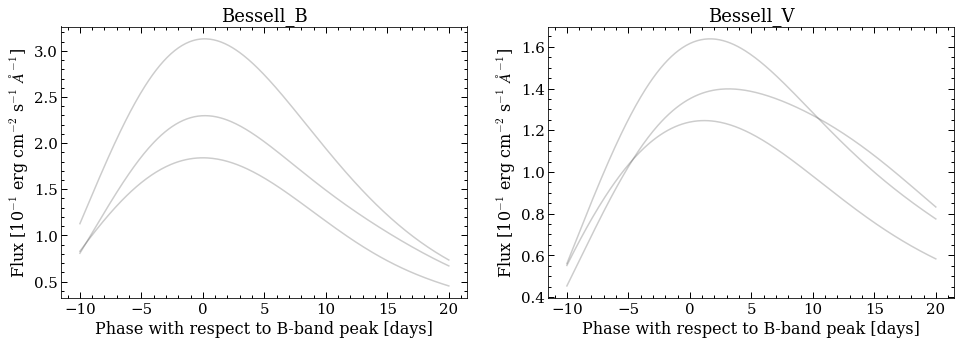

3 SNe in total


In [107]:
band1 = 'Bessell_B'
band2 = 'Bessell_V'

mask = features_df[band1].index.isin(features_df[band1].index.values[:40])
feature_values1 = features_df[band1][mask].copy()
feature_values1 = feature_values1.values
params_df1 = init_params_df[init_params_df.index.isin(features_df[band1].index.values)]

feature_values2 = features_df[band2].copy()
feature_values2 = feature_values2.values
params_df2 = init_params_df[init_params_df.index.isin(features_df[band2].index.values)]

# delete the SN with negative flux
pos_idx1 = [i for i, sn_values in enumerate(feature_values1) if all(sn_values>0.0)]
feature_values1 = feature_values1[pos_idx1]
params_df1 = params_df1.iloc[pos_idx1]
pos_idx2 = [i for i, sn_values in enumerate(feature_values2) if all(sn_values>0.0)] 
feature_values2 = feature_values2[pos_idx2]
params_df2 = params_df2.iloc[pos_idx2]

# delete other SNe by eye
delete = True
if delete:
    # band1
    sn2detele = delete_dict[band1]
    mask1 = params_df1.index.isin(sn2detele)
    params_df1 = params_df1[~mask1]
    feature_values1 = feature_values1[~mask1]
    
    # band2
    sn2detele = delete_dict[band2]
    mask2 = params_df2.index.isin(sn2detele)
    params_df2 = params_df2[~mask2]
    feature_values2 = feature_values2[~mask2]

# pick SNe in common
idx1 = [i for i, val in enumerate(params_df1.index.values) if val in params_df2.index.values]
feature_values1 = feature_values1[idx1]
params_df1 = params_df1.iloc[idx1]
idx2 = [i for i, val in enumerate(params_df2.index.values) if val in params_df1.index.values]
feature_values2 = feature_values2[idx2]
params_df2 = params_df2.iloc[idx2]


exp1 = np.round(np.log10(feature_values1[0].max()), 0)
y_norm1 = 10**exp1 
exp2 = np.round(np.log10(feature_values2[0].max()), 0)
y_norm2 = 10**exp2

f, ax = plt.subplots(1, 2, figsize=(16,5))

for val in feature_values1:
    ax[0].plot(phases, val/y_norm1, 'k', alpha=0.2)
    
ax[0].set_xlabel(f'Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax[0].set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp1, fontsize = 16, family='serif')
ax[0].set_title(f'{band1}', fontsize = 18, family='serif')
ax[0].minorticks_on()
ax[0].tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax[0].tick_params(which='minor', length=3, width=1, direction='in', top=True, right=True, labelsize=15)

for val in feature_values2:
    ax[1].plot(phases, val/y_norm2, 'k', alpha=0.2)
    
ax[1].set_xlabel(f'Phase with respect to B-band peak [days]', fontsize = 16, family='serif')
ax[1].set_ylabel(r'Flux [10$^{%.0f}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'%exp2, fontsize = 16, family='serif')
ax[1].set_title(f'{band2}', fontsize = 18, family='serif')
ax[1].minorticks_on()
ax[1].tick_params(which='major', length=6, width=1, direction='in', top=True, right=True, labelsize=15)
ax[1].tick_params(which='minor', length=3, width=1, direction='in', top=True, right=True, labelsize=15)

#plt.savefig(f'plots/lcs_{band}{y_label}.png')
plt.show()

print(f'{len(params_df1)} SNe in total')

In [105]:
features_matrix = np.asarray([feature_values1, feature_values2])
features_tensor  = tl.tensor(features_matrix.T)
print(features_tensor.shape)

(301, 3, 2)


### Parafac decomposition

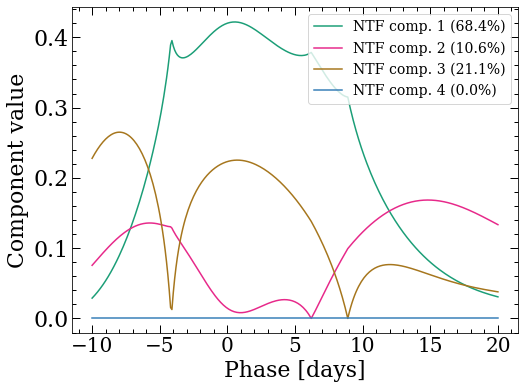

In [106]:
cp_rank = 4
random_state = 123

color_palette = [plt.get_cmap('Dark2')(i) for i in np.arange(8)] + [plt.get_cmap('Set1')(i) for i in np.arange(8)]
color_palette = color_palette[::3]

cp_factors = non_negative_parafac(features_tensor, cp_rank, random_state=random_state)
#cp_factors = parafac(features_tensor, cp_rank, random_state=random_state)
cp_reconstruction = tl.kruskal_to_tensor(cp_factors)

fig, ax = plt.subplots(figsize=(8, 6))
for i in np.arange(cp_factors[0].shape[1]):
    std = (cp_factors[0].T[i].var())/np.sum(cp_factors[0].T.var(axis=1))
    ax.plot(phases, cp_factors[0].T[i], label = f'NTF comp. {i+1} ({np.round(100*std, 1)}%)', color=color_palette[i])
    
#ax.set_title(f'B and V bands Decomposition')
ax.set_ylabel('Component value')
ax.set_xlabel('Phase [days]')
ax.legend(fontsize=14)

#plt.savefig('plots/tnf_components.pdf')
plt.show()

In [99]:
# reconstruction error
np.mean((cp_reconstruction-features_tensor)**2)
#np.mean(100*np.abs((cp_reconstruction-features_tensor)/features_tensor))

5.008188840728718e-06

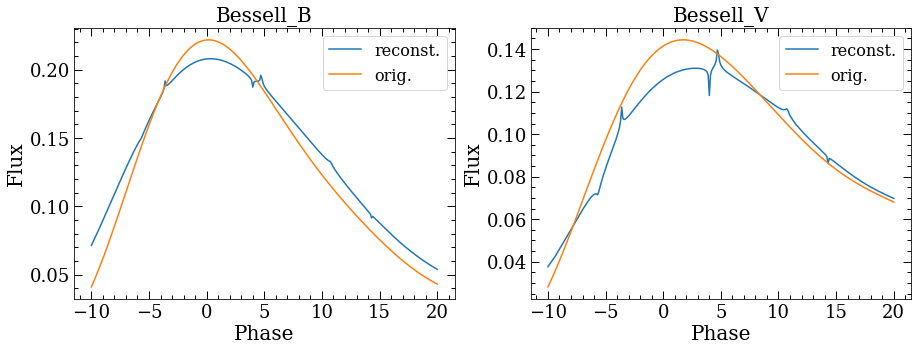

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sn_id = 5  # SN number

for k in np.arange(2):
    if k == 0:
        band = band1
    else:
        band = band2
        
    ax[k].plot(phases, cp_reconstruction[:, sn_id, k], label='reconst.')
    ax[k].plot(phases, features_tensor[:, sn_id, k], label='orig.')
    ax[k].set_title(f'{band}', fontsize=20)
    ax[k].set_ylabel('Flux', fontsize=20)
    ax[k].set_xlabel('Phase', fontsize=20)
    ax[k].tick_params(axis='both', which='major', labelsize=18)
    ax[k].legend(loc="upper right", fontsize=16)
    
#plt.savefig(f'plots/ntf_reconstruction.pdf')
plt.show()

Text(0.5, 0, 'Phase')

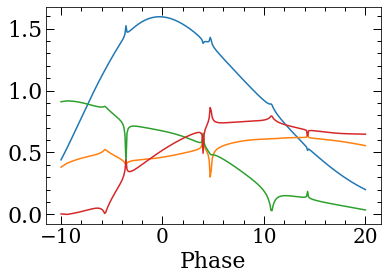

In [92]:
for i in range(cp_rank):
    plt.plot(phases, cp_factors[0].T[i])

plt.xlabel('Phase')

Text(0.5, 0, 'SN id')

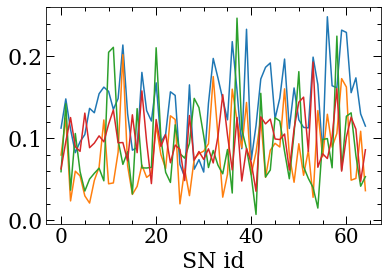

In [93]:
for i in range(cp_rank):
    plt.plot(cp_factors[1].T[i])
    
plt.xlabel('SN id')

Text(0.5, 0, 'Wavelength')

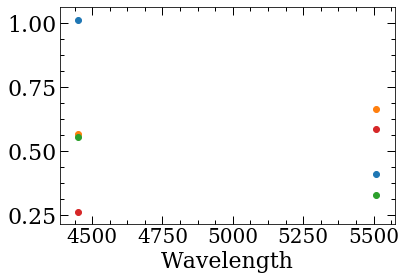

In [94]:
for i in range(cp_rank):
    plt.scatter([4450, 5510], cp_factors[2].T[i])

plt.xlabel('Wavelength')

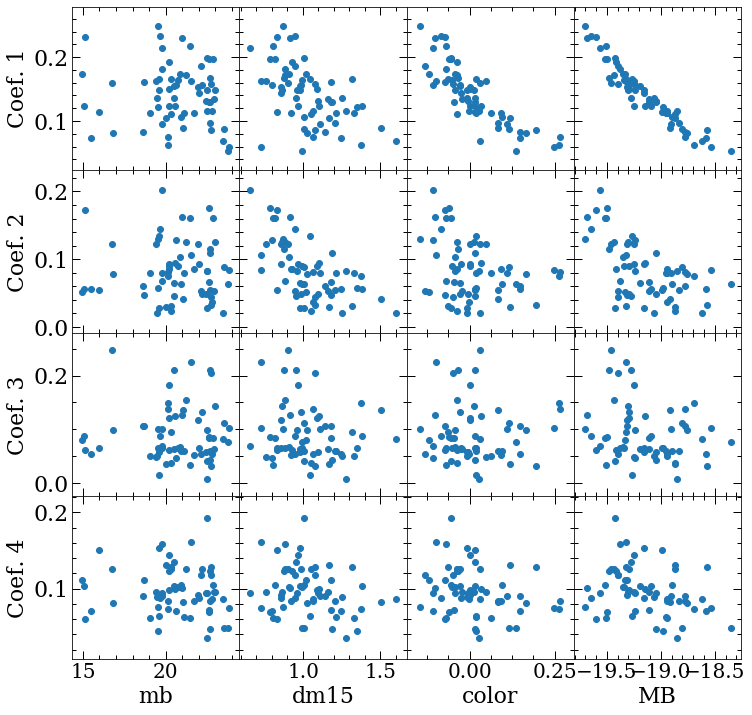

In [128]:
components_df = pd.DataFrame(data=cp_factors[1], columns=[f'CP{int(i+1)}' for i in np.arange(cp_rank)])
components_df['sn'] = params_df1.index.values
components_df = components_df.set_index('sn')

fig, ax = plt.subplots(cp_rank, 4, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(cp_rank):
    
    ax[i, 0].set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(4):
        
        ax[i, j].scatter(params_df1.values[:,j], components_df.values[:,i])
            
        if (i+1)==cp_rank:
            ax[i, j].set_xlabel(f'{params_df1.columns[j]}')  

#plt.savefig(f'plots/BV_ntf_coefficients.pdf')
plt.show()

### Tucker decomposition

In [64]:
#tucker_rank = [301, 36, 3]
tucker_rank = [4, 4, 4]

core, tucker_factors = non_negative_tucker(features_tensor, tucker_rank, init='random', tol=1e-6, random_state=random_state)
#core, tucker_factors = tucker(features_tensor, tucker_rank, init='random', tol=1e-6, random_state=random_state)
tucker_reconstruction = tl.tucker_to_tensor(core, tucker_factors)
print(tucker_factors[1].shape)

(140, 4)


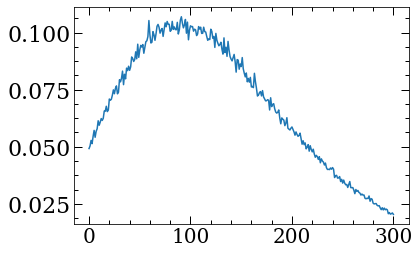

In [65]:
#plt.plot(tucker_factors[0].T[0]);
plt.plot(np.sum(tucker_factors[0], axis=1))

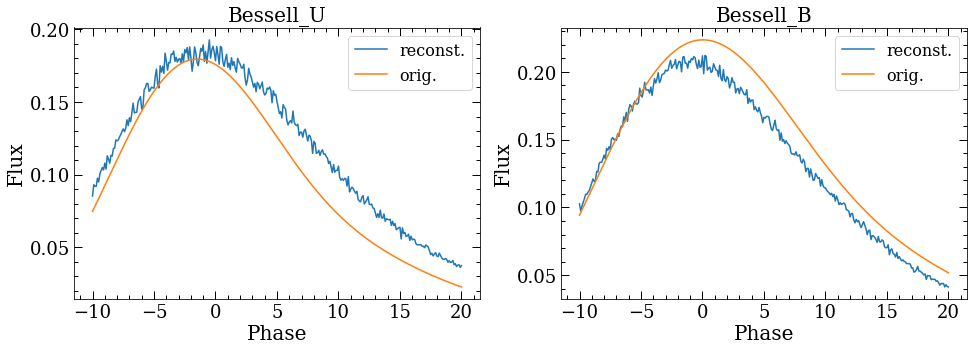

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
sn_id = 30  # SN number

for k in np.arange(2):
    if k == 0:
        band = band1
    else:
        band = band2
    
    ax[k].plot(phases, tucker_reconstruction[:, :, k].T[sn_id], label='reconst.')
    ax[k].plot(phases, features_tensor[:, sn_id, k], label='orig.')
    ax[k].set_title(f'{band}', fontsize=20)
    ax[k].set_ylabel('Flux', fontsize=20)
    ax[k].set_xlabel('Phase', fontsize=20)
    ax[k].tick_params(axis='both', which='major', labelsize=18)
    ax[k].legend(loc="upper right", fontsize=16)
    
plt.show()

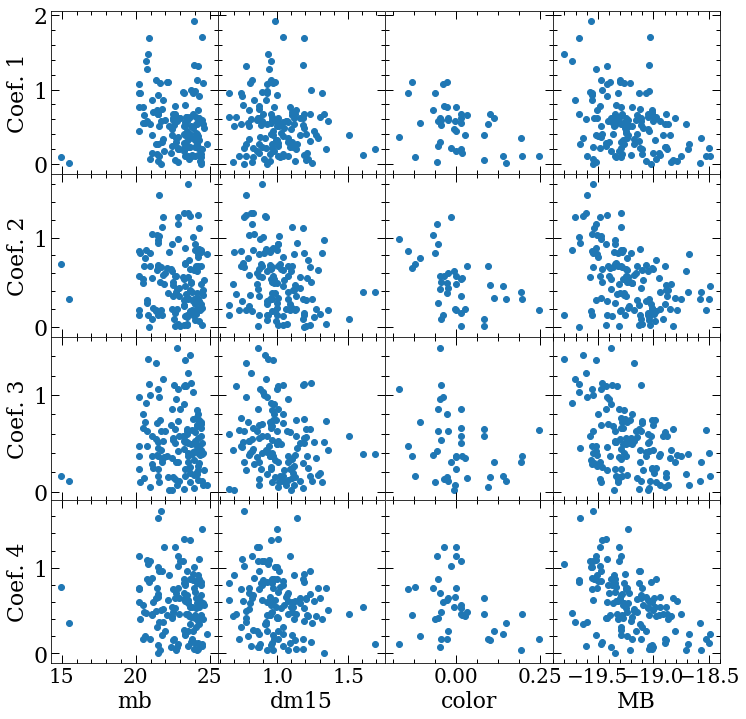

In [67]:
components_df = pd.DataFrame(data=tucker_factors[1], columns=[f'CP{int(i+1)}' for i in np.arange(tucker_rank[1])])
components_df['sn'] = params_df1.index.values
components_df = components_df.set_index('sn')

fig, ax = plt.subplots(tucker_rank[1], 4, figsize=(12, 12), 
                       sharex='col', sharey='row', gridspec_kw={'wspace':0, 'hspace':0})
for i in np.arange(tucker_rank[1]):
    
    ax[i, 0].set_ylabel(f'Coef. {int(i+1)}')
    for j in np.arange(4):
        
        ax[i, j].scatter(params_df1.values[:,j], components_df.values[:,i])
            
        if (i+1)==tucker_rank[1]:
            ax[i, j].set_xlabel(f'{params_df1.columns[j]}')  

plt.show()